In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from scipy.integrate import quad

## Physical constants

In [2]:
# Physical constants
pi = np.pi
angstron = 1e-10
hBar =  6.626086e-34/(2 * pi)
eV = 1.60217646e-19

# Electron constants
electronMass = 9.11e-31
electronMassBarrier = 0.0665 * electronMass

# Hole constant
holeMass = 2.18 * electronMass
holeMassBarrier = 0.33 * electronMass

## Model parameters

### Physical model parameters

In [3]:
# Temperatura [K]
T = 77.0

# Porção do offset da banda de condução [%]
offset = 70.0

### Quantum dot input parameters

In [4]:
# Quantum dot height [Angstrons]
heightQD = 40.0

# QUantum dot radius [Angstrons]
radiusQD = 100.0

# Wetting layer thickness [Angstrons]      
thicknessWL = 14 * 2.82675

# Cylinder height [Angstrons]
heightcylinder = 1600.0

# Cylinder radius [Angstrons]
radiuscylinder = 1600.0

# Concentration of In na liga de In_xGa_(1-x)As at the QD bottom
concentrationInAs_i = 0.0

# Concentration of In na liga de In_xGa_(1-x)As at the QD top
concentrationInAs_F = 100.0

# Particle mass on barrier in Kg
massBarrier = electronMassBarrier

# Define the valor of hz
posWL = ((radiusQD ** 2 -heightQD ** 2) / (2 * heightQD)) 

### Scale transformation

In [5]:
hQD = heightQD * angstron
r0 = radiusQD * angstron
hWL = thicknessWL * angstron
hC = heightcylinder * angstron
rC = radiuscylinder * angstron
h0 = posWL * angstron
x0 = concentrationInAs_i / 100.0
x1 = concentrationInAs_F / 100.0

R = hQD + h0

## Expansion parameters

In [6]:
# Max value of the quantum numbers
mmax = 0
lmax = 70
nmax = 50

# Matriz dimension
dimension = lmax * nmax

## Functions

In [65]:
def x(z):
    """
    Returns the InAs concentration along the z-axis

    Args:
        z (float): distance in z-axis

    Returns:
        float: InAs concentration
    """

    if  z <= h0 - hWL: 
            return 0

    if z > R:
        return 0

    if z <= h0:
        return 0

    return (x1 - x0) / (R - h0) * z + (x0 - h0 * (x1 - x0) / (R - h0))


def zQD(r):
    """
    Height of the QD in a radial distance r

    Args:
        r (float): Radial distance in Angstrons
    
    Returns:
        float: The height of the quantum dot in Angstrons
    """ 

    return np.sqrt(R ** 2 - r ** 2) - h0


def KroneckerDelta(i, j):
    """
    Kronecker delta

    Args:
        i (int): i index
        j (int): j index
    """
    return int(i == j)


def A_InGaAs(x):
    """
    Net parameter of In_XGa_(1-x)As in meters.

    Args:
        T (float): Temperature in K
        x (float): InAs Concentration
    """
    return (5.65325 + 3.88E-5 * (T - 300.0) + (0.40505 - 1.14E-5 * (T - 300.0)) * x) * angstron

In [55]:
def DivQD(x):
    """
    returns the number of discs in the division of the QD

    Args:
        T (float): Temperature in K
        x (float): Concentration of InAs
    """
    
    return (1 + np.round(hQD / (A_InGaAs(x) / 2))).astype(int)


def DivWL(x):
    """
    returns the number of discs in the division of the WL

    Args:
        T (float): Temperature in K
        x (float): Concentration of InAs
        hWL (float): Thickness of the WL
    """
    
    return (1 + np.round(hWL / (A_InGaAs(x) / 2))).astype(int)


def DeltaL_QD(x):
    """
    returns the thickness of discs in the division of the QD

    Args:
        T (float): Temperature in K
        x (float): Concentration of InAs
        hQD (float): Height of the QD
    """
    
    return hQD/DivQD(x)


def DeltaL_WL(x):
    """
    returns the thickness of discs in the division of the WL

    Args:
        T (float): Temperature in K
        x (float): Concentration of InAs
        hWL (float): Height of the QD
    """
    
    return hWL/DivWL(x)


def Rj(j):
    return np.sqrt(R ** 2 - (h0 + j * DivQD(x1)) ** 2)

In [10]:
def Mass1(x):
    """
    Parallel effective mass in unities of m0.

    Args:
        x (float): InAs Concentration
    """
    return (0.067 - 0.0131318 * x - 0.015862 * x ** 2) * electronMass


def Mass2(x):
    """
    Perpendicular effective mass in unities of m0.

    Args:
        x (float): InAs Concentration
    """
    return (0.067 - 0.000173691 * x - 0.0246154 * x ** 2) * electronMass


def v0(x):
    """
    The height of the potential barrier for the conduction band

    Args:
        x (float): InAs concentration

    Returns:
        float: The height of the barrier in eV
    """
    return (-0.0007938071289409138 + 0.5560814352172014 * x - 0.08851986807247743 * x ** 2) * eV


def k(m, n):
    """
    Bessel length

    Args:
        m (int): Order of the Bessel function
        n (int): Index of the Bessel root
    """
    return sc.jn_zeros(1, n + 1)[n] / rC




In [11]:
def Gll1(l, l1, z0, z1):
    """
    Solution of the sin integral G_{ll'}

    Args:
        l (int): Quantum number l
        l1 (int): Quantum number l
        z0 (float): Integral lower limit
        z1 (float): Integral upper limit

    Returns:
        float: Solution of the integral
    """
    
    if l != l1:
        f =  (0.5 * hC / pi) * ((np.sin((l + l1) * pi * (0.5 - z1 / hC)))/(l + l1) - (np.sin((l - l1) * pi * (0.5 - z1 / hC))) / (l - l1))
        f -= (0.5 * hC / pi) * ((np.sin((l + l1) * pi * (0.5 - z0 / hC)))/(l + l1) - (np.sin((l - l1) * pi * (0.5 - z0 / hC))) / (l - l1))
    else:
        f =  (-hC / pi) * ((pi / 2) * (0.5 - z1 / hC) - np.sin(2 * l * pi * (0.5 - z1 / hC)) / (4 * l))
        f -= (-hC / pi) * ((pi / 2) * (0.5 - z0 / hC) - np.sin(2 * l * pi * (0.5 - z0 / hC)) / (4 * l))
        
    return f


def Fll1(l, l1, z0, z1):
    """
    Solution of the sin integral F_{ll'}

    Args:
        l (int): Quantum number l
        l1 (int): Quantum number l
        z0 (float): Integral lower limit
        z1 (float): Integral upper limit

    Returns:
        float: Solution of the integral
    """
    
    if l != l1:
        f =  (-0.5 * hC / pi) * ((np.sin((l + l1) * pi * (0.5 - z1 / hC)))/(l + l1) + (np.sin((l - l1) * pi * (0.5 - z1 / hC))) / (l - l1))
        f -= (-0.5 * hC / pi) * ((np.sin((l + l1) * pi * (0.5 - z0 / hC)))/(l + l1) + (np.sin((l - l1) * pi * (0.5 - z0 / hC))) / (l - l1))
    else:
        f =  (-hC / pi) * (0.5 * pi * (0.5 - z1 / hC) + np.sin(2 * l * pi * (0.5 - z1 / hC))/(4 * l))
        f -= (-hC / pi) * (0.5 * pi * (0.5 - z0 / hC) + np.sin(2 * l * pi * (0.5 - z0 / hC))/(4 * l))
        
    return f

def i1 (l, m, n, l1, m1, n1):
    
    
    def fi1(r):
        return 2.0 * pi * r * sc.jv(m, k(m, n1) * r) * sc.jv(m, k(m, n) * r)
    
    

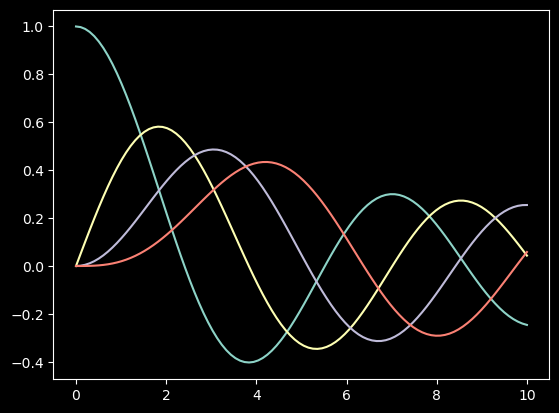

In [12]:
xr = np.linspace(0, 10, 100) 

for m in range(4):
    y = [sc.jv(m, x) for x in xr]
    plt.plot(xr, y)
plt.show()


### Eigen function normalization

In [13]:
def beta(m, n):
    """
    Normalization constant for each eigenfunction

    Args:
        m (int): Quantum number m
        n (int): Quantum number n

    Returns:
        The normalization constant for an eigenfunction
    """
    
    
    return np.sqrt(2 / (rC ** 2 * sc.jv(m + 1, k(m, n) * rC) * sc.jv(m + 1, k(m, n) * rC) * hC * pi))

In [34]:
n1

-1

### Matriz expansion constants

In [41]:
def P(l, m, n, l1, m1, n1):
    """
    Matriz element constant P

    Args:
        l (int): Quantum number l
        m (int): Quantum number m
        n (int): Quantum number n
        l1 (int): Quantum number l
        m1 (int): Quantum number m
        n1 (int): Quantum number n

    Returns:
        float: the value of the constant
    """
    return beta(m, n1) * beta(m, n) * KroneckerDelta(m, m1) * (l * pi / hC) * ( (l1 * pi / hC))


def Q(l, m, n, l1, m1, n1):
    """
    Matriz element constant P

    Args:
        l (int): Quantum number l
        m (int): Quantum number m
        n (int): Quantum number n
        l1 (int): Quantum number l
        m1 (int): Quantum number m
        n1 (int): Quantum number n

    Returns:
        float: the value of the constant
    """
    return beta(m, n1) * beta(m, n) * KroneckerDelta(m, m1) * k(m, n1) * k(m, n) / 2

### Free particle integral

In [15]:
def f(l, m, n, l1, m1, n1):
    """
    Returns the solution of the free particle integral
    inside a cylinder

    Args:
        l (int): Quantum number l
        m (int): Quantum number m
        n (int): Quantum number n
        l1 (int): Quantum number l
        m1 (int): Quantum number m
        n1 (int): Quantum number n
    """
    
    return (((hBar ** 2) / (2 * Mass1(0.0))) * ((l * pi / hC) ** 2 + k(m,n) ** 2)) * KroneckerDelta(m, m1) * KroneckerDelta(n, n1)

### Wetting layer integrals equations

$F_{l^\prime l}^{WL}$

In [16]:
def FllWL(i, l, l1):
    """_summary_

    Args:
        i (_type_): _description_
        l (_type_): _description_
        l1 (_type_): _description_

    Returns:
        _type_: _description_
    """
    if l1 != l:
        f =  (hC / 2) * np.sin(pi * (l1 + l) * (1/2 - (h0 - hWL + (i - 1) * DeltaL_WL(x1)) / hC)) / ((l1 + l) * pi)
        f += (hC / 2) * np.sin(pi * (l1 - l) * (1/2 - (h0 - hWL + (i - 1) * DeltaL_WL(x1)) / hC)) / ((l1 - l) * pi)
        f -= (hC / 2) * np.sin(pi * (l1 - l) * (1/2 - (h0 - hWL +  i      * DeltaL_WL(x1)) / hC)) / ((l1 - l) * pi)
        f -= (hC / 2) * np.sin(pi * (l1 + l) * (1/2 - (h0 - hWL +  i      * DeltaL_WL(x1)) / hC)) / ((l1 + l) * pi)
    else:
        f =  (hC / (4 * l * pi)) * np.sin(pi * l * ((hC - 2 * (h0 - hWL + (i - 1) * DeltaL_WL(x1)))/ hC))
        f -= (hC / (4 * l * pi)) * np.sin(pi * l * ((hC - 2 * (h0 - hWL +  i      * DeltaL_WL(x1)))/ hC))
        f += DeltaL_WL(x1) / 2
        
    return f

$G_{l^\prime l}^{WL}$

In [17]:
def GllWL(i, l, l1):
    """_summary_

    Args:
        i (_type_): _description_
        l (_type_): _description_
        l1 (_type_): _description_

    Returns:
        _type_: _description_
    """
    if l1 != l:
        f =  - (hC / 2) * np.sin(pi * (l1 + l) * (1/2 - (h0 - hWL + (i - 1) * DeltaL_WL(x1)) / hC)) / ((l1 + l) * pi)
        f +=   (hC / 2) * np.sin(pi * (l1 - l) * (1/2 - (h0 - hWL + (i - 1) * DeltaL_WL(x1)) / hC)) / ((l1 - l) * pi)
        f -=   (hC / 2) * np.sin(pi * (l1 - l) * (1/2 - (h0 - hWL +  i      * DeltaL_WL(x1)) / hC)) / ((l1 - l) * pi)
        f +=   (hC / 2) * np.sin(pi * (l1 + l) * (1/2 - (h0 - hWL +  i      * DeltaL_WL(x1)) / hC)) / ((l1 + l) * pi)
    else:
        f =  - (hC / (4 * l * pi)) * np.sin(pi * l * ((hC - 2 * (h0 - hWL + (i - 1) * DeltaL_WL(x1)))/ hC))
        f +=   (hC / (4 * l * pi)) * np.sin(pi * l * ((hC - 2 * (h0 - hWL +  i      * DeltaL_WL(x1)))/ hC))
        f +=   DeltaL_WL(x1) / 2
        
    return f

### Quantum dot integrals equations

$F_{l^\prime l}^{QD}$

In [18]:
def FllQD(i, l, l1):
    """_summary_

    Args:
        i (_type_): _description_
        l (_type_): _description_
        l1 (_type_): _description_

    Returns:
        _type_: _description_
    """
    if l1 != l:
        f =  (hC / 2) * np.sin(pi * (l1 + l) * (1/2 - (h0 + (i - 1) * DeltaL_QD(x1)) / hC)) / ((l1 + l) * pi)
        f += (hC / 2) * np.sin(pi * (l1 - l) * (1/2 - (h0 + (i - 1) * DeltaL_QD(x1)) / hC)) / ((l1 - l) * pi)
        f -= (hC / 2) * np.sin(pi * (l1 - l) * (1/2 - (h0 +  i      * DeltaL_QD(x1)) / hC)) / ((l1 - l) * pi)
        f -= (hC / 2) * np.sin(pi * (l1 + l) * (1/2 - (h0 +  i      * DeltaL_QD(x1)) / hC)) / ((l1 + l) * pi)
    else:
        f =  (hC / (4 * l * pi)) * np.sin(pi * l * ((hC - 2 * (h0 + (i - 1) * DeltaL_QD(x1)))/ hC))
        f -= (hC / (4 * l * pi)) * np.sin(pi * l * ((hC - 2 * (h0 +  i      * DeltaL_QD(x1)))/ hC))
        f += DeltaL_QD(x1) / 2
        
    return f

$G_{l^\prime l}^{QD}$

In [19]:
def GllWL(i, l, l1):
    """_summary_

    Args:
        i (_type_): _description_
        l (_type_): _description_
        l1 (_type_): _description_

    Returns:
        _type_: _description_
    """
    if l1 != l:
        f =  - (hC / 2) * np.sin(pi * (l1 + l) * (1/2 - (h0 + (i - 1) * DeltaL_QD(x1)) / hC)) / ((l1 + l) * pi)
        f +=   (hC / 2) * np.sin(pi * (l1 - l) * (1/2 - (h0 + (i - 1) * DeltaL_QD(x1)) / hC)) / ((l1 - l) * pi)
        f -=   (hC / 2) * np.sin(pi * (l1 - l) * (1/2 - (h0 +  i      * DeltaL_QD(x1)) / hC)) / ((l1 - l) * pi)
        f +=   (hC / 2) * np.sin(pi * (l1 + l) * (1/2 - (h0 +  i      * DeltaL_QD(x1)) / hC)) / ((l1 + l) * pi)
    else:
        f =  - (hC / (4 * l * pi)) * np.sin(pi * l * ((hC - 2 * (h0 + (i - 1) * DeltaL_WL(x1)))/ hC))
        f +=   (hC / (4 * l * pi)) * np.sin(pi * l * ((hC - 2 * (h0 +  i      * DeltaL_WL(x1)))/ hC))
        f +=   DeltaL_QD(x1) / 2
        
    return f

## Matrix calculation

### $l^\prime \ne l$

#### First integral
$$
    P\int_0^{R_c}{2\pi r J_m(k_{mn^\prime} r) J_m(k_{mn} r) dr} \times \sum_{i = 1}^{M}{\left(\frac{\hbar^2}{2 m_{2j}^*} - \frac{\hbar^2}{2 m_{B}^*}\right)F_{l^\prime l}^{WL}(i)}
$$

In [56]:
def I1(l, m, n, l1, m1, n1):
    
    def f(r):
            return 2 * pi * r * sc.jv(m, k(m, n1) * r) * sc.jv(m, k(m, n) * r)
    integ = quad(f, 0, rC)[0]
        
    p = P(l, m, n, l1, m1, n1)
    sum = np.sum(np.array([(hBar ** 2 /(2 * Mass2(x(h0 - i * DeltaL_WL(x1)))) - hBar ** 2/(2 * Mass1(0))) * FllWL(i, l, l1) for i in range(1, DivWL(x1) + 1)]))
    
    return p * integ * sum

In [67]:
np.array([x(h0 - hWL + i * DeltaL_WL(x1)) for i in range(1, DivWL(x1) + 1)])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])